# CNN for One Step prediction of All Cells

## 1. Load the dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('dataset.csv', index_col='Timestamp')
df.head()

,Cell_000111,Cell_000112,Cell_000113,Cell_000231,Cell_000232,Cell_000233,Cell_000461,Cell_000462,Cell_000463,Cell_000821,...,Cell_006653,Cell_006661,Cell_006662,Cell_006663,Cell_007371,Cell_007372,Cell_007373,Cell_039871,Cell_039872,Cell_039873
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-23 00:00:00,29.26490,59.15291,59.01721,2.63658,14.11635,3.37565,7.69811,0.62042,0.74651,0.00000,...,36.89798,148.60854,98.66328,6.60830,0.82699,3.27327,80.90784,18.22045,6.99716,1.73569
2017-10-23 01:00:00,19.26170,60.22876,40.34814,13.16293,0.96246,7.47019,31.07216,0.52249,14.31437,19.78196,...,35.80842,11.13813,0.43016,1.45869,0.73014,0.35795,1.58017,38.19131,9.75174,7.38484
2017-10-23 02:00:00,18.37236,14.83900,1.27435,25.36683,1.07481,3.88256,26.14190,1.10567,27.31817,0.00000,...,42.86074,39.93543,0.28038,1.09835,0.38237,0.66306,0.75476,1.29435,3.66695,2.57090
2017-10-23 03:00:00,18.69268,0.98166,2.11746,1.66842,0.85055,14.04557,0.56444,0.50090,12.28002,0.00000,...,55.43529,10.91845,4.04031,5.95218,0.50307,0.26729,1.32703,1.01926,0.17117,11.62664
2017-10-23 04:00:00,21.62559,4.28219,3.51484,1.78151,0.71691,12.94846,27.45815,17.99582,5.18661,0.00033,...,16.57459,46.98406,0.89364,5.47769,4.58068,0.30167,1.20668,0.82393,123.40943,28.72087


## 2. Fill NaNs

In [3]:
ndf = df.interpolate(method='linear', axis=1) # linear interpolate
#ndf = df.fillna(method='ffill', axis=1) # forward the last valid observation
ndf = df.fillna(0) # fill remaned nans with 0s
ndf.isna().sum().sum()

0

## 3. Train-Test Split

In [4]:
data = ndf.values
data = data.astype('float32')
ratio = 0.8
train_size = int(ratio*len(data))
train = data[:train_size]
test = data[train_size:]
print(train.shape)
print(test.shape)

(6990, 57)
(1748, 57)


## 4. Normalization

In [5]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

## 5. Time Series Generators

In [47]:
days_back = 3 # back days for prediction
input_steps = 24*days_back 
output_steps = 1 
batch_size = 10
train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(train,
                                                                train,
                                                                length=input_steps,
                                                                batch_size=batch_size)
test_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(test,
                                                               test,
                                                               length=input_steps,
                                                               batch_size=batch_size)

In [48]:
print("Number of train samples: ", len(train_gen))
print("Number of test samples: ", len(test_gen))

Number of train samples:  692
Number of test samples:  168


## 6. CNN Model

In [49]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=32,
                                 kernel_size=4,
                                 activation='relu',
                                 input_shape=(input_steps, train.shape[1])))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=16,
                                 kernel_size=2,
                                 activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(train.shape[1], activation='linear'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 69, 32)            7328      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 68, 16)            1040      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1088)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               139392    
_________________________________________________________________
dense_13 (Dense)             (None, 57)                7353      
Total params: 155,113
Trainable params: 155,113
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam',
             loss='mean_squared_error')

## 7. Train Model

In [51]:
history = model.fit(train_gen,
                    epochs=30,
                    validation_data=test_gen,
                    verbose=1)

Epoch 1/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0076 - val_loss: 0.0154
Epoch 2/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0066 - val_loss: 0.0148
Epoch 3/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0063 - val_loss: 0.0150
Epoch 4/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0062 - val_loss: 0.0150
Epoch 5/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0061 - val_loss: 0.0148
Epoch 6/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0060 - val_loss: 0.0145
Epoch 7/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0060 - val_loss: 0.0153
Epoch 8/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0058 - val_loss: 0.0145
Epoch 9/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0058 - val_loss: 0.0152
Epoch 10/30
692/692 [==============================] - 2s 3ms/step - loss: 0.0056 - val_loss: 0.0148

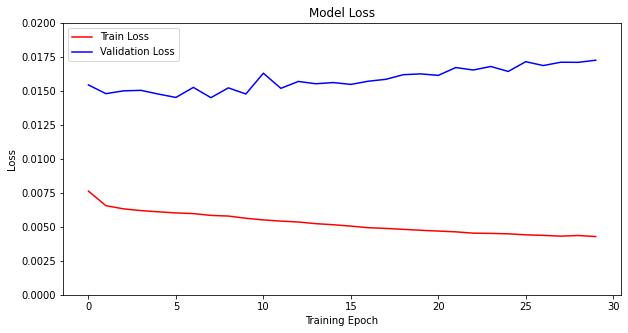

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Train Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim((0,0.02))
plt.legend()
plt.show()

In [53]:
print(f'Minimum MSE of CNN is {min(val_loss)}')

Minimum MSE of CNN is 0.014505576342344284
